In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264,
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24,
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['jazz'] = [ 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
                  0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
                  1, 1, 1, 1, 0, 0, 1, 1, 0, 0]

# Tuning KNN

Although KNN is a relatively simple model, there are several things that you can do to tune its performance. These primarily have to do with how you handle distance and how many neighbors you include.

## Distance and normalizing

In the previous lesson, you learned about the distance measure that's used for deciding how close other observations are to a test point. But you still need to learn about some important nuances in measuring distance. **Specifically, the measurement makes the assumption that all units are equal.** So, in the previous example, being one loudness unit away is equivalent to being one second away. This is intensely problematic; it's one of the main issues that people have with KNN. Units are rarely equivalent, and determining how to adjust that inequivalence is an abstract and touchy subject. **This difficulty also makes it nearly impossible to include binary or categorical variables in a KNN model; it really is best if the variables are continuous.**

This issue can be more obvious if you're dealing with something where the relative scales are strikingly different. For example, if you were looking at buildings, and you had height in floors and area in square footage, you'd have a model that would really only care about square footage. That's because distance in that dimension would be a far greater number of units than the number of floors.

To deal with this, data scientists typically use *normalization* techniques. Normalization is a way of taking these seemingly incommensurate measures and making them comparable. There are two main normalization techniques that are effective with KNN:

1. You can set the bounds of the data to `0` and `1`, and then rescale every variable to be within those bounds. (It may also be reasonable to use `-1` and `1` as the bounds, but the difference is actually immaterial.) This way, every data point is measured in terms of its distance between the maximum and minimum of its category. This is best if the data shows a linear relationship, such that scaling to a `0` to `1` range makes logical sense. It is also best if there are known limits to the dataset, because those provide logical bounds for `0` and `1` for the rescaling.

2. You can also calculate how far each observation is from the mean, expressed in the number of standard deviations. This is often called *z-scores*. Calculating z-scores and using them as your basis for measuring distance works for continuous data. It puts everything in terms of how far from the mean it is (or how "abnormal" it is).

Either of these techniques is viable for most situations, and you'll have to use your intuition to see which makes the most sense. Mixing them, although possible, is usually a dangerous proposition.

## Weighting

There is one more thing to address when talking about distance, and that is weighting. In the vanilla version of KNN, all $k$ of the closest observations are given equal votes on what the outcome of the test observation should be. When the data is densely populated, that isn't necessarily a problem. Particularly if there is variance in the measurement itself, it can be wise to avoid trying to draw information from small differences in distance.

However, sometimes the $k$ nearest observations are not all similarly close to the test. In that case, it may be useful to weight by distance. Functionally, you will weight by the inverse of distance, so that closer data points (with a low distance) have a higher weight than further ones.

Scikit-learn again makes this quite easy to implement. There is an optional `weights` parameter that you can use when defining the model. If you set that parameter to `distance`, you will use distance weighting.

Try it below and see how it affects your model. The code below also uses the stats module from SciPy to convert the data to z-scores.

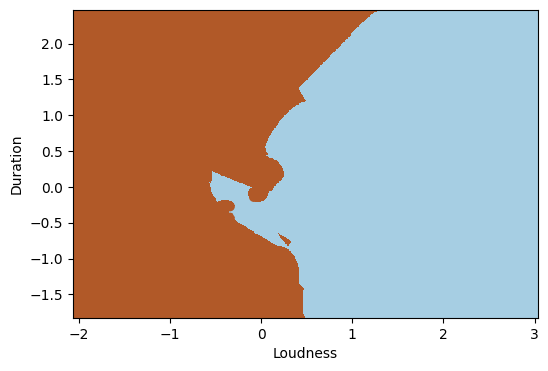

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

# The input DataFrame will be the z-scores this time instead of raw data
X = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

# Fit the model
Y = music.jazz
neighbors.fit(X.values, Y)

# Arrays, not DataFrames, for the mesh
X = np.array(X.values)
Y = np.array(Y)

# Mesh size
h = .01

# Plot the decision boundary and assign a color to each point in the mesh
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

This is a much more nuanced decision boundary than before. But it's also relatively continuous and consistent, providing a nice sense of which regions are likely to belong to which classification.


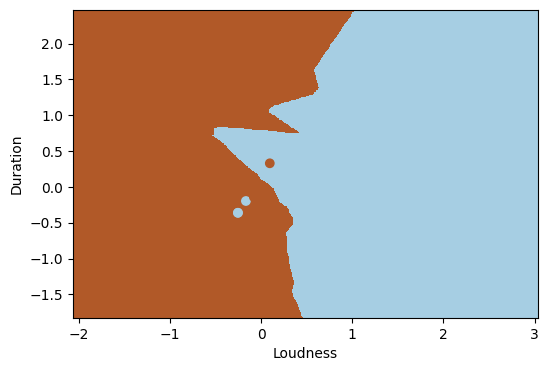

In [3]:
# Trying weighting all points in each neighborhood equally and increasing
# number of neighbors to 10.
neighbors = KNeighborsClassifier(n_neighbors=10, weights='uniform')

# The input DataFrame will be the z-scores this time instead of raw data
X = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

# Fit the model
Y = music.jazz
neighbors.fit(X.values, Y)

# Arrays, not DataFrames, for the mesh
X = np.array(X.values)
Y = np.array(Y)

# Mesh size
h = .01

# Plot the decision boundary and assign a color to each point in the mesh
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

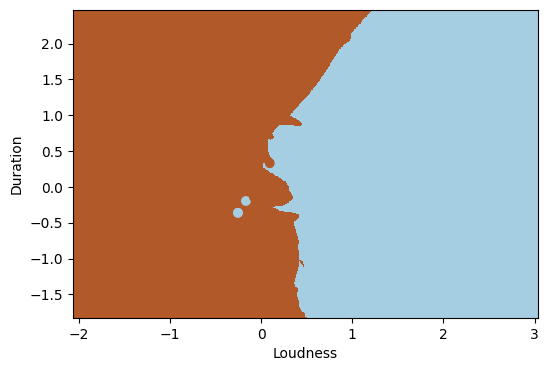

In [4]:
import numpy as np
def customized_weights(distances: np.array)->np.array:
    max_dist = 50
    weights: np.array = np.array(np.full(distances.shape, 0), dtype='float')
    # create a new array 'weights' with the same dimension of  'distances' and fill
    # the array with 0 element.
    for i in range(distances.shape[0]): # for each prediction:
        if distances[i, 0] >= max_dist: # if the smaller distance is greather than max distance,
                                   # consider the nearest neighbor's weight as 1
                                   # and the neighbor weights will stay zero
            weights[i, 0] = 1
                                   # than continue to the next prediction
            continue

        for j in range(distances.shape[1]): # aply the weight function for each distance

            if (distances[i, j] >= max_dist):
                continue

            weights[i, j] = 1 - distances[i, j]/max_dist

    return weights

# Trying a custom distance function and setting the number of neighbors to 8.
neighbors = KNeighborsClassifier(n_neighbors=8, weights=customized_weights)

# The input DataFrame will be the z-scores this time instead of raw data
X = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

# Fit the model
Y = music.jazz
neighbors.fit(X.values, Y)

# Arrays, not DataFrames, for the mesh
X = np.array(X.values)
Y = np.array(Y)

# Mesh size
h = .01

# Plot the decision boundary and assign a color to each point in the mesh
x_min = X[:,0].min() - .5
x_max = X[:,0].max() + .5
y_min = X[:,1].min() - .5
y_max = X[:,1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('Loudness')
plt.ylabel('Duration')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

## Choosing k

The last major aspect of tuning KNN is picking $k$. This choice is largely up to the data scientist building the model, but there are some things to consider.

Choosing a value for $k$ is a tradeoff. The larger the $k$, the more smoothed out your decision space will be, with more observations getting a vote in the prediction. A smaller $k$ will pick up more subtle deviations, but these deviations could be just randomness, and therefore you could just be overfitting. Add in weighting, and that's an additional dimension to this entire conversation.

In the end, the best technique is probably to try multiple models and use your validation techniques to see which is best. In particular, k-fold cross-validation is a great way to see how your KNN model is performing.

## Drill

Imagine that you work at a credit card company and you're trying to figure out if people are going to pay their bills on time. You have everyone's purchases split into four main categories: groceries, dining out, utilities, and entertainment. What are some ways that you might use KNN to create this model? What aspects of KNN would be useful? For your own purposes, write up your thoughts and document how you'd approach this challenge.

**Answer**

The KNN algorithm faces two difficulties: it becomes computationally more expensive to compute distance and find the nearest neighbors in high-dimensional space. With two categories, this isn't a major problem. In higher-dimensional space, the KNN algorithm is limited by the curse of dimensionality.

With four categories (groceries, dining out, utilities, entertainment) and a thousand customers, this shouldn't be a huge problem. However, most large credit card companies likely have millions of customers. So, the cost of calculating distances between the new point and each existing point one million times is huge, which degrades performance. I wouldn't use the KNN algorithm on this problem. To make it computationally efficient, you would have to use a small value for the number of neighbors which would degrade perfomance.